# Transfer Learning
---
**Transfer learning의 배경**
* Convolution network을 처음부터 학습시키는 것은 시간과 자원이 많이 든다.
* 복잡한 모델일수록 학습시키기 어렵다. 
* 실질적으로 처음부터 학습시키려면 많은 시도가 필요


* 마지막으로 Fully connected layer를 제외한 모든 것을 fixed feature extractor로 사용한다.
* 새로운 최종 Classifier layer를 정의하고 훈련에 적용한다.

---

## 꽃 이미지 분류하기

pretrained model 을 사용하여 꽃 이미지를 분류한다. 

### Download Data

다음의 링크를 클릭하여 꽃 이미지를 다운로드 한다. [this link](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/September/5baa60a0_flower-photos/flower-photos.zip)   
다운로드한 zip파일을 `flower_photos/`에 압축해제한다. **압축해제하고 꽃이름으로 된 하위 폴더의 사진 이미지를 확인한다.**

In [1]:
import os
import numpy as np
import torch

import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is not available.  Training on CPU ...


## Load and Transform our Data

PyTorch의 [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder)를 사용하면 디렉토리로 부터 손쉽게 이미지를 load할 수 있다. 예를 들면 저장된 파일 이미지의 디렉토리 구조가 다음과 같다:
```
root/class_1/xxx.png
root/class_1/xxy.png
root/class_1/xxz.png

root/class_2/123.png
root/class_2/nsdf3.png
root/class_2/asd932_.png
```

이번 예제에서는 꽃 이미지의 훈련데이터가 `flower_photos/train/` 에 있고 꽃 이름(label)으로 폴더의 이름이 붙여져 있다.

In [3]:
# define training and test data directories
data_dir = 'flower_photos/'
train_dir = os.path.join(data_dir, 'train/')
test_dir = os.path.join(data_dir, 'test/')

# classes are folders in each directory with these names
classes = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

### Transforming the Data

pre-trained model 을 사용하여 transfer learning을 수행하기 위해서 이미지를 적절하게 전처리 해야 한다.
`224 x 224` images 크기를 입력으로 사용한다. 따라서 입력 되는 꽃 이미지도 해당 사이즈로 resize해야 한다.

In [5]:
# load and transform data using ImageFolder

# VGG-16 Takes 224x224 images as input, so we resize all of them
data_transform = transforms.Compose([transforms.RandomResizedCrop(224), 
                                      transforms.ToTensor()])

train_data = datasets.ImageFolder(train_dir, transform=data_transform)
test_data = datasets.ImageFolder(test_dir, transform=data_transform)

# print out some data stats
print('Num training images: ', len(train_data))
print('Num test images: ', len(test_data))

Num training images:  3130
Num test images:  540


### DataLoaders and Data Visualization

In [6]:
# define dataloader parameters
batch_size = 20
num_workers=0

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)

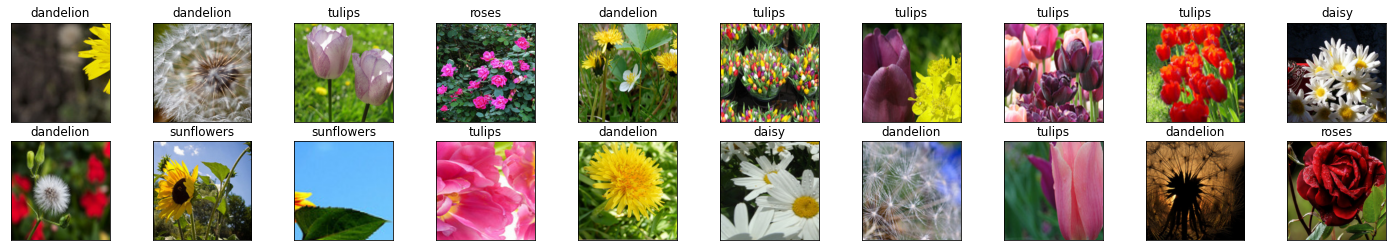

In [7]:
# Visualize some sample data

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

---
## Define the Model

다음의 순서로 모형을 생성한다.:
1. pre-trained model을 load한다.
2. fixed feature extractor 로 사용하기 위해 모든 가중치 정보를 "Freeze" 한다.
3. 마지막의 fully connected layer는 삭제한다.
4. 마지막 Classifier를 꽃 이미지를 분류하기 알맞게 변경한다.

**가중치를 Freezing 한다는 것은 pre-trained model 애서 해당 가중치 정보가 훈련 중에 업데이트 되지 않도록 한다는 것이다.**

In [8]:
# Load the pretrained model from pytorch
import os

os.environ['TORCH_HOME'] = '../models'

m_v2 = models.mobilenet_v2(pretrained=True)

# print out the model structure
print(m_v2)

MobileNetV2(
  (features): Sequential(
    (0): ConvBNActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momen

In [9]:
print(m_v2.classifier[1].in_features) 
print(m_v2.classifier[1].out_features) 

1280
1000


In [10]:
# Freeze training for all "features" layers
for param in m_v2.features.parameters():
    param.requires_grad = False
    

---
---
### Final Classifier Layer

pre-trained feature extractor를 설정했다면 마지막 classifier에 해당하는 fully-connected layer를 추가하거나 변경한다.   
> 마지막  Classifier Layer는 우리가 분류하고자하는 꽃 이미지에 맞도록 적절한 output size를 지정해야 한다.
이름과 번호를 사용하여 pretrained network에 access할 수 있다. 예를 들면 `.classifier[6]`는 classifier group의 6번째 레이어를 가르킨다.

## 실습하기:   
마지막  last fully-connected layer 를 꽃 이미지를 분류하기 알맞은 형태로 설정하시오.

In [11]:
import torch.nn as nn

n_inputs = m_v2.classifier[1].in_features

# add last linear layer (n_inputs -> 5 flower classes)
# new layers automatically have requires_grad = True
last_layer = nn.Linear(n_inputs, len(classes))

m_v2.classifier[1] = last_layer

# if GPU is available, move the model to GPU
if train_on_gpu:
    m_v2.cuda()

# check to see that your last layer produces the expected number of outputs
print(m_v2.classifier[1].out_features)
print(m_v2)

5
MobileNetV2(
  (features): Sequential(
    (0): ConvBNActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, mom

### Specify [Loss Function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [Optimizer](http://pytorch.org/docs/stable/optim.html)

cross-entropy loss 와 stochastic gradient descent를 사용한다. learning rate를 적절히 선택한다. 

In [12]:
import torch.optim as optim

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer (stochastic gradient descent) and learning rate = 0.001
optimizer = optim.SGD(m_v2.classifier.parameters(), lr=0.001)

---
## Training


## 실습하기
> **실습:** 해답을 참조하여 모형을 훈련하고 결과를 확인한다.

In [13]:
# number of epochs to train the model
n_epochs = 2

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    # model by default is set to train
    for batch_i, (data, target) in enumerate(train_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = m_v2(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss 
        train_loss += loss.item()
        
        if batch_i % 20 == 19:    # print training loss every specified number of mini-batches
            print('Epoch %d, Batch %d loss: %.16f' %
                  (epoch, batch_i + 1, train_loss / 20))
            train_loss = 0.0

Epoch 1, Batch 20 loss: 1.5836171090602875
Epoch 1, Batch 40 loss: 1.4870851874351501
Epoch 1, Batch 60 loss: 1.4063808619976044
Epoch 1, Batch 80 loss: 1.3653543114662170
Epoch 1, Batch 100 loss: 1.3101124286651611
Epoch 1, Batch 120 loss: 1.2451018869876862
Epoch 1, Batch 140 loss: 1.2170774459838867
Epoch 2, Batch 20 loss: 1.1410203397274017
Epoch 2, Batch 40 loss: 1.0930459320545196
Epoch 2, Batch 60 loss: 1.0846079736948013
Epoch 2, Batch 80 loss: 1.0311370730400085
Epoch 2, Batch 100 loss: 0.9973105281591416
Epoch 2, Batch 120 loss: 1.0069104224443435
Epoch 2, Batch 140 loss: 0.9276999771595001


---
## Testing

테스트 데이터를 사용하여 flower class 분류기를 평가한다.

In [14]:
# track test loss 
# over 5 flower classes
test_loss = 0.0
class_correct = list(0. for i in range(5))
class_total = list(0. for i in range(5))

m_v2.eval() # eval mode

# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = m_v2(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update  test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(5):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.882990

Test Accuracy of daisy: 77% (71/92)
Test Accuracy of dandelion: 92% (122/132)
Test Accuracy of roses: 59% (54/91)
Test Accuracy of sunflowers: 84% (85/101)
Test Accuracy of tulips: 71% (89/124)

Test Accuracy (Overall): 77% (421/540)


### Visualize Sample Test Results

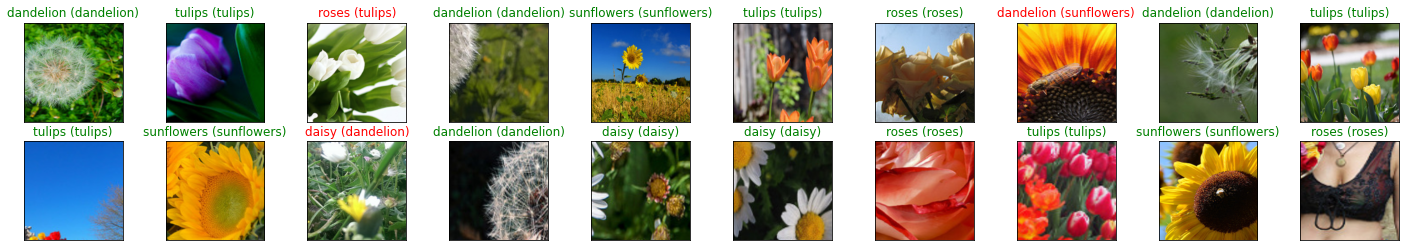

In [15]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

m_v2.eval() # eval mode
# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = m_v2(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))